### encode

In [33]:
def allocate_subcarriers(f: float):
    """
    指定された周波数帯域をサブキャリアで隙間なく埋める。

    Args:
        f (float): サブキャリア幅 (Hz)

    Returns:
        tuple: サブキャリアの数 (int) と中心周波数と帯域フラグのリスト (list of tuples)
    """
    # 利用周波数帯域の定義
    bands = [(2000, 14000, "audible"), (18000, 22000, "near_inaudible")]  # (下限, 上限, フラグ) のリスト

    # サブキャリアの中心周波数を格納するリスト
    subcarriers = []

    for band_start, band_end, flag in bands:
        freq = band_start + f / 2  # 最初のサブキャリアの中心周波数
        i = 0

        while freq+f/2 <= band_end:
            subcarriers.append((freq, flag, i))
            i += 1
            freq = band_start + f / 2 + i * f  # 次のサブキャリアの中心周波数

    return len(subcarriers), subcarriers


# 使用例
f = 370  # サブキャリア幅 (Hz)
num_subcarrier, subcarrier_list = allocate_subcarriers(f)

print(f"サブキャリアの数: {num_subcarrier}")
print(f"中心周波数リストとフラグ: {subcarrier_list}")

サブキャリアの数: 42
中心周波数リストとフラグ: [(2185.0, 'audible', 0), (2555.0, 'audible', 1), (2925.0, 'audible', 2), (3295.0, 'audible', 3), (3665.0, 'audible', 4), (4035.0, 'audible', 5), (4405.0, 'audible', 6), (4775.0, 'audible', 7), (5145.0, 'audible', 8), (5515.0, 'audible', 9), (5885.0, 'audible', 10), (6255.0, 'audible', 11), (6625.0, 'audible', 12), (6995.0, 'audible', 13), (7365.0, 'audible', 14), (7735.0, 'audible', 15), (8105.0, 'audible', 16), (8475.0, 'audible', 17), (8845.0, 'audible', 18), (9215.0, 'audible', 19), (9585.0, 'audible', 20), (9955.0, 'audible', 21), (10325.0, 'audible', 22), (10695.0, 'audible', 23), (11065.0, 'audible', 24), (11435.0, 'audible', 25), (11805.0, 'audible', 26), (12175.0, 'audible', 27), (12545.0, 'audible', 28), (12915.0, 'audible', 29), (13285.0, 'audible', 30), (13655.0, 'audible', 31), (18185.0, 'near_inaudible', 0), (18555.0, 'near_inaudible', 1), (18925.0, 'near_inaudible', 2), (19295.0, 'near_inaudible', 3), (19665.0, 'near_inaudible', 4), (20035.0, 'n

In [34]:
# DBPSK

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio


def DBPSK(X, X_former, symbols, idx):
    if idx != 0:
        for i in range(len(subcarrier_list)):
            bit = symbols[i][idx-1]
            if subcarrier_list[i][1] == "near_inaudible":
                # 近非可聴域は振幅を立てる
                center = int(frame_length*(subcarrier_list[i][0]/44100))
                for j in range(9):
                    nearly_inaudible_amp = 10
                    if bit == 1:
                        # 1のとき（πずらす）
                        X[center+j] = nearly_inaudible_amp*np.exp(1j*(np.angle(X_former[center+j]) + np.pi))
                        X[center-j] = nearly_inaudible_amp*np.exp(1j*(np.angle(X_former[center-j])+ np.pi))
                        X[frame_length - center - j] = nearly_inaudible_amp * np.exp(-1j * (np.angle(X_former[center + j]) + np.pi))
                        X[frame_length - center + j] = nearly_inaudible_amp * np.exp(-1j * (np.angle(X_former[center - j]) + np.pi))
                    else:
                        # 0のとき（何もずらさない）
                        X[center+j] = nearly_inaudible_amp*np.exp(1j*(np.angle(X_former[center+j])))
                        X[center-j] = nearly_inaudible_amp*np.exp(1j*(np.angle(X_former[center-j])))
                        X[frame_length - center -j] = nearly_inaudible_amp*np.exp(-1j*(np.angle(X_former[center+j])))
                        X[frame_length - center + j] = nearly_inaudible_amp * np.exp(-1j * (np.angle(X_former[center - j])))
            elif subcarrier_list[i][1] == "audible":
                # 可聴域は振幅はそのまま
                center = int(frame_length * (subcarrier_list[i][0] / 44100))
                for j in range(5): 
                    if bit == 1:
                        # 1のとき（πずらす）
                        X[center+j] = np.abs(X[center+j])*np.exp(1j*(np.angle(X_former[center+j]) + np.pi))
                        X[center-j] = np.abs(X[center-j])*np.exp(1j*(np.angle(X_former[center-j])+ np.pi))
                        X[frame_length - center - j] = np.abs(X[center + j]) * np.exp(
                            -1j * (np.angle(X_former[center + j]) + np.pi)
                        )
                        X[frame_length - center + j] = np.abs(X[center - j]) * np.exp(
                            -1j * (np.angle(X_former[center - j]) + np.pi)
                        )
                    else:
                        # 0のとき（何もずらさない）
                        X[center+j] = np.abs(X[center+j])*np.exp(1j*(np.angle(X_former[center+j])))
                        X[center-j] = np.abs(X[center-j])*np.exp(1j*(np.angle(X_former[center-j])))
                        X[frame_length - center - j] = np.abs(X[center + j]) * np.exp(-1j * (np.angle(X_former[center + j])))
                        X[frame_length - center + j] = np.abs(X[center - j]) * np.exp(-1j * (np.angle(X_former[center - j])))
    return X


# 音源ファイルを読み込み
# input_filename = "wav/egaotonamida.wav"
# input_filename = "wav/wakaindashi.wav"
input_filename = "exp/rock.wav"
# input_filename = "exp/speech.wav"
# input_filename = "exp/flamenco2.wav"
# input_filename = "released_audios/1_B_original.wav"
original_signal, _ = sf.read(input_filename)

# 音声データがステレオの場合はモノラルに変換
if original_signal.ndim > 1:
    original_signal = original_signal.mean(axis=1)

original_signal = original_signal / np.max(np.abs(original_signal))

print(np.max(np.abs(original_signal)))

# パラメータを設定
samplerate = 44100
frame_length = 2048
# frame_length = 4096
subcarrier_width = 370
num_frame = len(original_signal) // frame_length
freqs = np.fft.fftfreq(frame_length, 1 / 44100)

# フレーム数を指定
num_frame = 200


# サブキャリアの位置
num_subcarrier, subcarrier_list = allocate_subcarriers(subcarrier_width)

# 埋め込むビット列
symbols = [np.random.choice([0, 1], size=num_frame).tolist() for _ in range(num_subcarrier)]
print(symbols)


# ハニング窓
hanning_window = np.hanning(frame_length)

# 新しいデータ配列を初期化
s3_signal = np.zeros(num_frame * frame_length)
s1_signal_mod = np.zeros(num_frame * frame_length)
s2_signal = np.zeros(num_frame * frame_length)

print(f"frame_length : {frame_length}")
print(f"num_frame : {num_frame}")
print(f"subcarrier_width : {subcarrier_width}")
print(f"subcarrier_width_pt : {frame_length*(subcarrier_width/44100)}")
print(f"num_subcarrier : {num_subcarrier}")

# 各フレームでFFTを行い、位相を変更
for i in range(0, num_frame-1):
    start = i * frame_length
    end = start + frame_length
    s1_frame = hanning_window * original_signal[start:end]
    s2_frame = hanning_window * original_signal[start + frame_length // 2 : end + frame_length // 2]

    s1_frame_fft = np.fft.fft(s1_frame)

    if i == 0:
        s1_frame_fft_former = np.copy(s1_frame_fft)

    s1_frame_fft_mod = DBPSK(s1_frame_fft, s1_frame_fft_former, symbols, i)

    s1_frame_mod = np.fft.ifft(s1_frame_fft_mod)
    s1_frame_fft_former = np.copy(s1_frame_fft_mod)

    for j in range(frame_length):
        s3_signal[start + j] += s1_frame_mod[j].real
        s1_signal_mod[start + j] += s1_frame_mod[j].real
        if i < num_frame:
            s3_signal[start + frame_length // 2 + j] += s2_frame[j].real
            s2_signal[start + frame_length // 2 + j] += s2_frame[j].real

# output_filename = "exp/speech_110.wav"
# output_filename = "exp/pop_2000.wav"
# output_filename = "exp/example_mod.wav"
output_filename = "mod.wav"
# output_filename = "test_2.wav"
sf.write(output_filename, s3_signal, samplerate)

1.0
[[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,

In [97]:
Audio(input_filename, autoplay=True)

In [99]:
Audio(output_filename, autoplay=True)

### decode

Recording ...
Done.


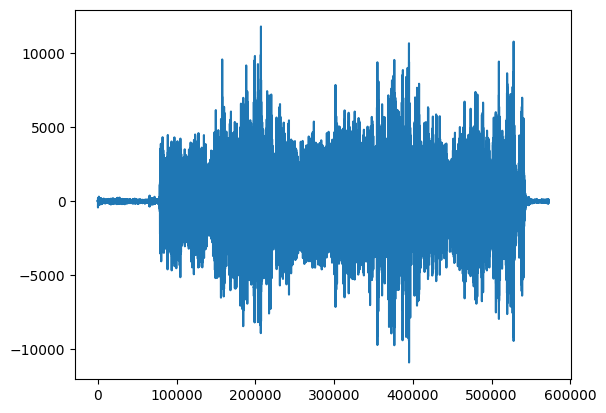

In [172]:
import pyaudio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

CHUNK = 2**10
# CHUNK = 4410
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
record_time = 13

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("Recording ...")
frames = []
for i in range(0, int(RATE / CHUNK * record_time)):
    data = stream.read(CHUNK)
    frames.extend(np.frombuffer(data, dtype=np.int16))

print("Done.")

stream.stop_stream()
stream.close()
p.terminate()

plt.plot(frames)

frames = np.column_stack((frames, frames))

output_filename = 'wav/recorded_mac_1_noise.wav'
sf.write(output_filename, frames, 44100)

In [173]:
# 元音源と相関をとって音源開始位置を特定

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# input_recorded = "wav/recorded.wav"
input_recorded = "wav/recorded_mac_1_noise.wav"
signal_recorded, samplerate = sf.read(input_recorded)

input_original = "exp/rock.wav"
# input_original = "exp/pop.wav"
# input_original = "exp/speech.wav"
# input_original = "exp/flamenco2.wav"
signal_original, samplerate = sf.read(input_original)

# 音声データがステレオの場合はモノラルに変換
if signal_recorded.ndim > 1:
    signal_recorded = signal_recorded.mean(axis=1)
if signal_original.ndim > 1:
    signal_original = signal_original.mean(axis=1)


# 相互相関の計算
correlation = np.correlate(signal_recorded[:200000], signal_original[:100000], mode="valid")

# 最大値のインデックスを取得
max_index = np.argmax(correlation)

# 結果の表示
print(f"相互相関: {correlation}")
print(f"最大値のインデックス: {max_index}")

相互相関: [14.51927083 13.55006862 12.94142576 ... -3.30154777 -3.92857175
 -4.34650373]
最大値のインデックス: 78385


In [116]:
samplerate

16000

79017


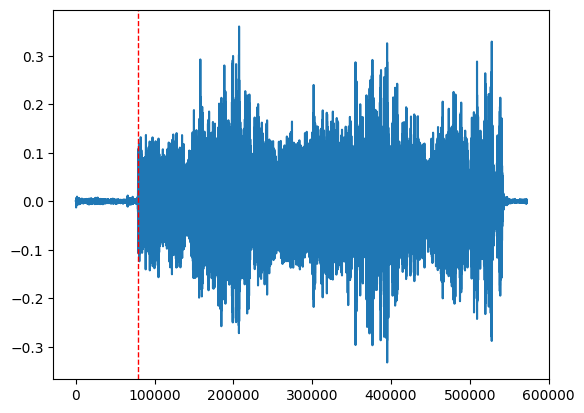

In [174]:
# 設定した閾値を超える位置から音源の開始位置を特定

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt


# input_filename = 'wav/recorded.wav'
input_filename = "wav/recorded_mac_1_noise.wav"

received_signal, samplerate = sf.read(input_filename)

# 音声データがステレオの場合はモノラルに変換
if received_signal.ndim > 1:
    received_signal = received_signal.mean(axis=1)

for i in range(0, 100000):
    if abs(received_signal[i]) > 0.06:
        print(i)
        break

plt.plot(received_signal)
# plt.xlim(20000, 40000)
# plt.xlim(500000, 600000)
plt.axvline(x=max_index, color="r", linestyle="--", linewidth=1)

In [175]:
data = received_signal[max_index:]

print(f"len(data) : {len(data)}")
print(f"frame_length : {frame_length}")
print(f"num_frame : {num_frame}")
print(f"subcarrier_width : {subcarrier_width}")
print(f"subcarrier_width_pt : {frame_length*(subcarrier_width/44100)}")
print(f"num_subcarrier : {num_subcarrier}")

hanning_window = np.hanning(frame_length)


errors = []
decoded_bits = [[0] * (num_frame) for _ in range(num_subcarrier)]

decode_success = [[0] * (num_frame) for _ in range(num_subcarrier)]

for i in range(num_frame - 1):
    if i != 0:
        print(f"time {i}")
        print("----------------------------")

    decode_frame = hanning_window * data[frame_length * i : frame_length * (i + 1)]
    frame_fft = np.fft.fft(decode_frame)

    if i == 0:
        frame_fft_former = np.copy(frame_fft)
    else:
        for k in range(len(subcarrier_list)):
            center = int(frame_length*(subcarrier_list[k][0]/44100))
            if subcarrier_list[k][1] == "audible":
                S = 0
                for j in range(9):
                    frame_fft_angle = np.angle(frame_fft[center - 4 + j])
                    frame_fft_former_angle = np.angle(frame_fft_former[center - 4 + j])
                    d = abs(frame_fft_angle - frame_fft_former_angle)
                    if np.pi < d < 2 * np.pi:
                        d = 2 * np.pi - d
                    print(d)
                    S += d
                if S / 9 > np.pi / 2:
                    decoded_bits[k][i - 1] = 1
                else:
                    decoded_bits[k][i - 1] = 0
                print(f"decoded : {decoded_bits[k][i-1]}")
                print(f"symbol : {symbols[k][i-1]}")
                if decoded_bits[k][i - 1] != symbols[k][i - 1]:
                    print("####################   error!!!   ####################")
                    errors.append(subcarrier_list[k][0])
                else:
                    decode_success[k][i - 1] = 1
                print("----------------------------")
            else:
                S = 0
                for j in range(17):
                    frame_fft_angle = np.angle(frame_fft[center - 8 + j])
                    frame_fft_former_angle = np.angle(frame_fft_former[center - 8 + j])
                    d = abs(frame_fft_angle - frame_fft_former_angle)
                    if np.pi < d < 2 * np.pi:
                        d = 2 * np.pi - d
                    print(d)
                    S += d
                if S / 17 > np.pi / 2:
                    decoded_bits[k][i - 1] = 1
                else:
                    decoded_bits[k][i - 1] = 0
                print(f"decoded : {decoded_bits[k][i-1]}")
                print(f"symbol : {symbols[k][i-1]}")
                if decoded_bits[k][i - 1] != symbols[k][i - 1]:
                    print("####################   error!!!   ####################")
                    errors.append(subcarrier_list[k][0])
                else:
                    decode_success[k][i - 1] = 1
                print("----------------------------")
        frame_fft_former = np.copy(frame_fft)
    print("------------------------------------------------------------------------")

print(decoded_bits)

len(data) : 494031
frame_length : 2048
num_frame : 200
subcarrier_width : 370
subcarrier_width_pt : 17.182766439909297
num_subcarrier : 42
------------------------------------------------------------------------
time 1
----------------------------
2.309193749751455
2.831585820426401
3.1384182712836264
3.037318638934184
2.358098050483995
2.434207278300134
2.1488010410200262
1.603030233896364
2.5378723414952944
decoded : 1
symbol : 1
----------------------------
2.9089275484961825
2.1370161892519888
0.7653571051722401
0.11306665299487129
1.3020751041959469
0.8229834555075826
0.03913058521058388
0.0882513734920316
0.7236877660789884
decoded : 0
symbol : 0
----------------------------
0.2476947599604551
0.0632696093037346
0.42119283827937193
0.1489662119327384
0.6197879939008266
0.40839689109507726
0.18503287975843197
0.21492501472965517
0.08485281782407794
decoded : 0
symbol : 0
----------------------------
1.2232155204401598
0.38188565929941737
1.1547707806990894
1.8732492232926923
0.400

In [176]:
from collections import Counter

frequency_distribution = Counter(errors)

# 度数分布表の表示
for value, frequency in sorted(frequency_distribution.items()):
    print(f"Value: {value}, Frequency: {frequency}")

Value: 2185.0, Frequency: 3
Value: 2555.0, Frequency: 6
Value: 2925.0, Frequency: 1
Value: 3295.0, Frequency: 9
Value: 3665.0, Frequency: 2
Value: 4035.0, Frequency: 7
Value: 4405.0, Frequency: 3
Value: 4775.0, Frequency: 26
Value: 5145.0, Frequency: 65
Value: 5515.0, Frequency: 22
Value: 5885.0, Frequency: 22
Value: 6255.0, Frequency: 2
Value: 6995.0, Frequency: 1
Value: 8105.0, Frequency: 2
Value: 11805.0, Frequency: 1
Value: 12915.0, Frequency: 1
Value: 13285.0, Frequency: 3
Value: 13655.0, Frequency: 9
Value: 18555.0, Frequency: 1
Value: 19665.0, Frequency: 1
Value: 20035.0, Frequency: 1
Value: 20405.0, Frequency: 1
Value: 20775.0, Frequency: 1


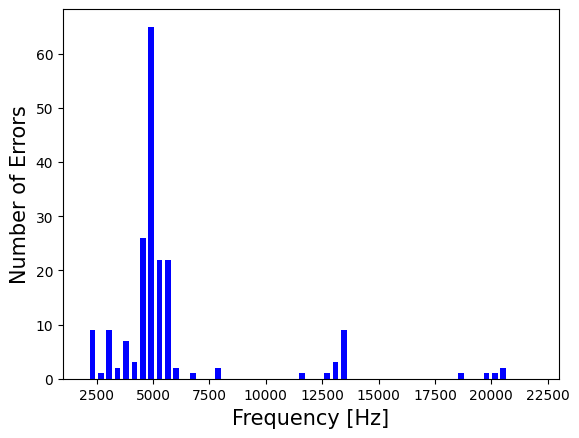

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを描画
plt.hist(errors, bins=50, width = 250, alpha=1, color="blue")

# グラフの装飾
# plt.title("Error Frequency Distribution")
plt.ylabel("Number of Errors", fontsize = 15)
plt.xlabel("Frequency [Hz]", fontsize=15)
plt.xlim(1000, 23000)
# グラフを表示
plt.show()

In [168]:
decoding_rate = [0] * (num_frame - 2)
for j in range(num_frame-2):
    s = 0
    for i in range(num_subcarrier):
        if symbols[i][j] == decoded_bits[i][j]:
            s += 1
    print(f"time {j+1} : {s/num_subcarrier}")
    decoding_rate[j] = s / num_subcarrier

time 1 : 0.9523809523809523
time 2 : 1.0
time 3 : 1.0
time 4 : 1.0
time 5 : 1.0
time 6 : 1.0
time 7 : 1.0
time 8 : 1.0
time 9 : 1.0
time 10 : 1.0
time 11 : 1.0
time 12 : 1.0
time 13 : 1.0
time 14 : 0.9761904761904762
time 15 : 1.0
time 16 : 1.0
time 17 : 0.9761904761904762
time 18 : 1.0
time 19 : 1.0
time 20 : 1.0
time 21 : 1.0
time 22 : 1.0
time 23 : 0.9761904761904762
time 24 : 1.0
time 25 : 1.0
time 26 : 1.0
time 27 : 1.0
time 28 : 0.9761904761904762
time 29 : 0.9761904761904762
time 30 : 1.0
time 31 : 1.0
time 32 : 1.0
time 33 : 0.9761904761904762
time 34 : 1.0
time 35 : 1.0
time 36 : 1.0
time 37 : 1.0
time 38 : 1.0
time 39 : 0.9761904761904762
time 40 : 0.9761904761904762
time 41 : 0.9285714285714286
time 42 : 0.9761904761904762
time 43 : 1.0
time 44 : 1.0
time 45 : 1.0
time 46 : 1.0
time 47 : 1.0
time 48 : 1.0
time 49 : 0.9761904761904762
time 50 : 0.9761904761904762
time 51 : 1.0
time 52 : 1.0
time 53 : 1.0
time 54 : 1.0
time 55 : 1.0
time 56 : 1.0
time 57 : 1.0
time 58 : 1.0
ti

In [181]:
s=0
for j in range(num_frame-2):
    for i in range(num_subcarrier):
        if symbols[i][j] == decoded_bits[i][j]:
            s += 1
print(f"BER : {(((num_frame-2)*num_subcarrier)-s)/((num_frame-2)*num_subcarrier)}")
print(f"Decording Rate : {1 - (((num_frame-2)*num_subcarrier)-s)/((num_frame-2)*num_subcarrier)}")

BER : 0.02284752284752285
Decording Rate : 0.9771524771524771


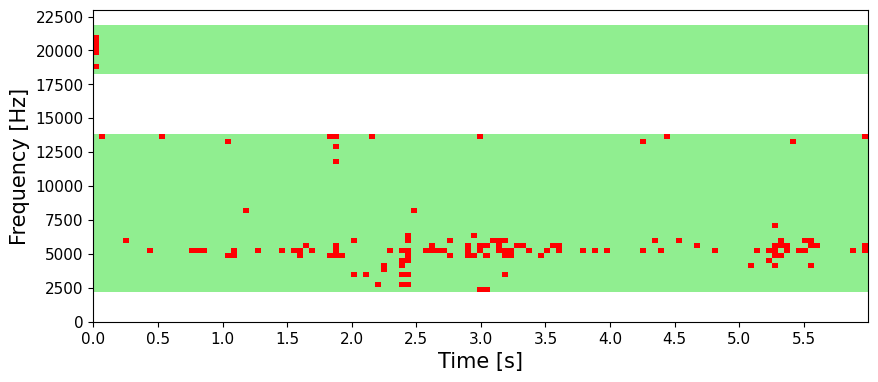

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# カスタムカラーマップ（1: 黄緑, 0: 赤, 未割当: 灰色）
cmap = ListedColormap(["red", "lightgreen", "white"])

# 時間範囲の設定
start_time = 0
end_time = 6
start_frame = int(start_time * samplerate / frame_length)
end_frame = int(end_time * samplerate / frame_length)

# 0〜23kHzの範囲における背景グリッドを作成
freq_min = 0
freq_max = 23000
freq_bins = np.arange(freq_min, freq_max, f)  # 周波数の範囲をサブキャリア幅で区切る
background = np.full((len(freq_bins), end_frame), 2)  # 2 = 灰色（未割当エリア）

# 指定範囲のデータを取得
subset = np.array([row[start_frame:end_frame] for row in decode_success])

# 各サブキャリアのデータを背景グリッドに反映
for i, (freq, _, sub_idx) in enumerate(subcarrier_list):
    freq_bin_idx = np.searchsorted(freq_bins, freq)  # どの周波数ビンに入るか
    background[freq_bin_idx, : subset.shape[1]] = subset[i, :]  # 成功/失敗データを適用

# プロットの準備
fig, ax = plt.subplots(figsize=(10, 6))

# イメージ表示（赤=失敗, 黄緑=成功, 灰色=未割当エリア）
ax.imshow(
    background,
    aspect=0.000105,
    cmap=cmap,
    extent=[start_time, end_time, freq_min, freq_max],
    origin="lower",
    vmin=0,
    vmax=2,  # 0=赤（失敗）, 1=黄緑（成功）, 2=灰色（未割当）
)

# 軸ラベル
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("Frequency [Hz]", fontsize=15)

# 周波数軸の目盛り調整
freq_ticks = np.arange(0, 24000, 2500)  # 2.5kHz間隔でラベルを付ける
time_ticks = np.arange(start_time, end_time, 0.5)  # 0.5秒間隔でラベルを付ける
ax.set_xticks(time_ticks)
ax.set_yticks(freq_ticks)
ax.set_yticklabels([int(freq) for freq in freq_ticks])
ax.tick_params(axis="both", labelsize=11)

# 図を表示
plt.show()